In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
print(X_motion_CoM_acceleration.shape)
print(Y_motion_CoM_acceleration.shape)

(17248, 24)
(17248, 3)


In [6]:
X_motion_CoM_acceleration[0]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.09097510576248169,
       0.015695713460445404, 0.03546101972460747, -0.07442539185285568,
       0.2557870149612427, 0.1313159465789795, -0.3803728222846985,
       0.2226693332195282, -0.12780198454856873, -0.3819510042667389,
       -0.2751573324203491, 0.1259901523590088, -0.38960644602775574,
       -0.2416217029094696, -0.1263108104467392, -0.38173601031303406,
       False, True], dtype=object)

In [7]:
Y_motion_CoM_acceleration[0]

array([0.026377092776805316, -0.0005811629410078806,
       -0.0013480793902780341], dtype=object)

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM_acceleration[:, -1] == 1)[0]
X_motion_CoM_acceleration_FR_RL = X_motion_CoM_acceleration[idx_fr_rl_swinging]
Y_motion_CoM_acceleration_FR_RL = Y_motion_CoM_acceleration[idx_fr_rl_swinging]
print(X_motion_CoM_acceleration_FR_RL.shape)
print(Y_motion_CoM_acceleration_FR_RL.shape)

(8610, 24)
(8610, 3)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_acceleration_FR_RL[0, :]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.09097510576248169,
       0.015695713460445404, 0.03546101972460747, -0.07442539185285568,
       0.2557870149612427, 0.1313159465789795, -0.3803728222846985,
       0.2226693332195282, -0.12780198454856873, -0.3819510042667389,
       -0.2751573324203491, 0.1259901523590088, -0.38960644602775574,
       -0.2416217029094696, -0.1263108104467392, -0.38173601031303406,
       False, True], dtype=object)

In [11]:
Y_motion_CoM_acceleration_FR_RL[0, :]

array([0.026377092776805316, -0.0005811629410078806,
       -0.0013480793902780341], dtype=object)

### Linear Regression

In [12]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [13]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 6:7], # actual velocity
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 10:12], # FL position
               X_motion_CoM_acceleration_FR_RL[:, 13:15], # FR position
               X_motion_CoM_acceleration_FR_RL[:, 16:18], # RL position
               X_motion_CoM_acceleration_FR_RL[:, 19:21])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_x = find_best_model(X, Y, runs=5000)

R2:  0.9876808539604061
RMSE:  0.009831804649368982
The lowest error is:  2.0921257031930596e-06
The highest error is:  0.03940361139715848
The avg. error is:  0.00691539588469112


In [14]:
model_fr_com_x.coef_

array([[ 0.21180696,  0.08733433,  0.39375494,  0.20741955, -0.45455263,
         0.29056373,  0.26806324, -0.04667911, -0.66246393, -0.27890029]])

In [15]:
model_fr_com_x.intercept_

array([-0.10674002])

Text(0, 0.5, 'Predictions')

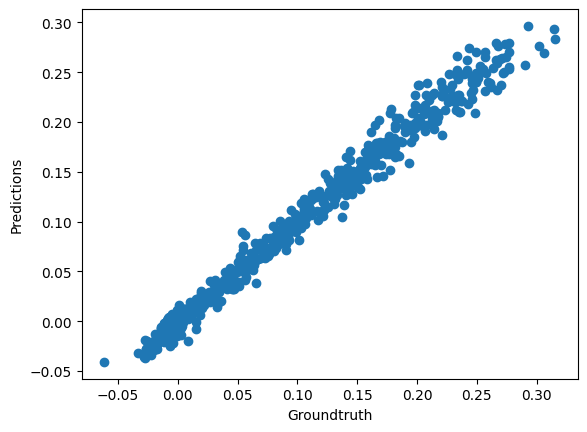

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [18]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> y

### Linear Regression

In [17]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 6:7], # actual velocity
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 10:12], # FL position
               X_motion_CoM_acceleration_FR_RL[:, 13:15], # FR position
               X_motion_CoM_acceleration_FR_RL[:, 16:18], # RL position
               X_motion_CoM_acceleration_FR_RL[:, 19:21])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_y = find_best_model(X, Y, runs=5000)

R2:  0.4871840544322561
RMSE:  0.0033264301870553014
The lowest error is:  4.461573350063915e-06
The highest error is:  0.010580040209905623
The avg. error is:  0.0026052156753530835


In [18]:
model_fr_com_y.coef_

array([[-0.04381483,  0.0099718 , -0.01461114,  0.10550614, -0.09817355,
        -0.37950534,  0.03110533, -0.31907396,  0.23638129,  0.26928122]])

In [19]:
model_fr_com_y.intercept_

array([0.10893133])

Text(0, 0.5, 'Predictions')

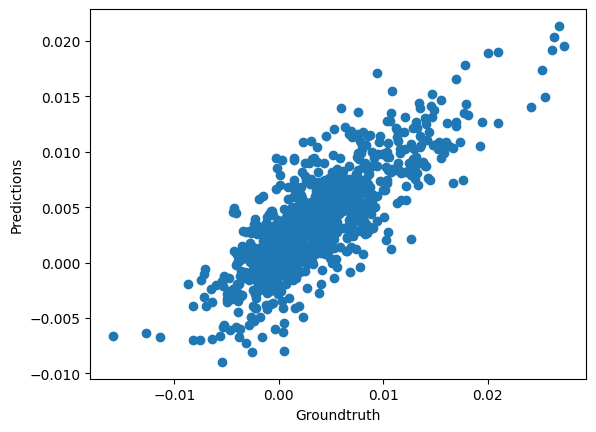

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')